## Leitura e pré-processamento dos dados
A base utilizada foi obtida por meio de uma técnica web-scrapping da rede social GoodReads, cujo foco são os livros. Cada livro possui uma página de onde é possível retirar diversas informações tais como autor, idioma, número de páginas e descrição. Todas as informações foram obtidas a partir de um projeto do scrapy, que pode ser encontrado na pasta "goodreads_scraper". No total, foram obtidos dados de mais 54 mil livros diferentes, que foram salvos em um arquivo json lines.

In [1]:
import json

with open('books.jl', 'r') as file:
    books = [json.loads(line) for line in file]
    
len(books)

54703

Porém nem todos os livros estão aptos para análise. Para começar, definiu-se que será analisado livros na língua inglesa por ser um idioma com mais estudo a respeito de técnicas de processamento de linguagem natural. Além disso, livros sem descrição, ou sem gênero foram retirados da base.

In [2]:
import pandas as pd

books_df = pd.DataFrame(books)

books_df = books_df.loc[books_df['description'].str.len() != 0]
books_df = books_df.loc[books_df['shelves'].str.len() != 0]

books_df['language'] = books_df['language'].astype('category')
books_df = books_df.loc[books_df['language'] == 'English']

print(len(books_df))
books_df.head()

41677


,title,description,book_id,language,pages,authors,rating,rating_count,review_count,shelves
1,Slake's Limbo: 121 Days,[An ALA Best Books for Young Adults An ALA Not...,1038268.Slake_s_Limbo,English,128,[Felice Holman],3.49,"[\n , \n 631\n ratings\n]","[\n , \n 86\n reviews\n]","[Young Adult, 18 users, Fiction, 18 users, Rea..."
2,Going Solo,"[Superb Stories, Daring Deeds, Fantastic Adven...",6678.Going_Solo,English,209,"[Roald Dahl, Quentin Blake]",4.08,"[\n , \n 22,355\n ratings\n]","[\n , \n 1,399\n reviews\n]","[Nonfiction, 444 users, Biography, 280 users, ..."
3,Chronicle of a Blood Merchant,[One of the last decade's ten most influential...,334970.Chronicle_of_a_Blood_Merchant,English,263,"[Yu Hua, Andrew Jones]",4.06,"[\n , \n 3,097\n ratings\n]","[\n , \n 358\n reviews\n]","[Cultural, China, 96 users, Fiction, 89 users,..."
5,The Unholy Cause,[A Supernatural novel that reveals a previou...,6767583-the-unholy-cause,English,320,[Joe Schreiber],4.11,"[\n , \n 2,274\n ratings\n]","[\n , \n 136\n reviews\n]","[Fantasy, Supernatural, 239 users, Fantasy, 51..."
6,She Said!: The Book of Quotes,"[""She Said!"" is my ode to words, in the form o...",42088819-she-said,English,124,[Chriselda Barretto],4.19,"[\n , \n 373\n ratings\n]","[\n , \n 7\n reviews\n]","[Adult, 21 users, New Adult, 20 users, Fiction..."


A maior parte dos dados foi extraída de uma maneira mais crua, sendo necessário um pré-tratamento para facilitar a análise dos dados, convertendo algumas colunas para outros formatos e limpando a formatação.

In [3]:
import re

books_df['description'] = books_df['description'].apply(lambda x:x[-1])
books_df['book_id'] = books_df['book_id'].apply(lambda x:int(re.findall(r'\d+', x)[0]))
books_df['pages'] = pd.to_numeric(books_df['pages'])
books_df['rating'] = pd.to_numeric(books_df['rating'])
books_df['rating_count'] = books_df['rating_count'].apply(lambda x:int(re.findall(r'\d+', x[-1].replace(',', ''))[0]))
books_df['review_count'] = books_df['review_count'].apply(lambda x:int(re.findall(r'\d+', x[-1].replace(',', ''))[0]))

O gênero não é extraído da melhor maneira possível, assim é necessário uma função para retirar apenas a parte importante. Ao entramos no site do GoodReads, vemos que as vezes, um gênero é quebrado em um subgênero e o número corresponde apenas a esse sub-gênero, então queremos pegar apenas a tag do subgênero e a quantidade referente.

In [4]:
def proc_shelves(shelves):
    string = '*'.join(shelves).replace(',','')
    lista = re.findall(r'[\w\s]+\*\d+',string)
    return {shelf.split('*')[0]:shelf.split('*')[1] for shelf in lista}
books_df['shelves'] = books_df['shelves'].apply(proc_shelves)
books_df.head()

,title,description,book_id,language,pages,authors,rating,rating_count,review_count,shelves
1,Slake's Limbo: 121 Days,An ALA Best Books for Young Adults An ALA Nota...,1038268,English,128.0,[Felice Holman],3.49,631,86,"{'Young Adult': '18', 'Fiction': '18', 'Realis..."
2,Going Solo,"Superb Stories, Daring Deeds, Fantastic Advent...",6678,English,209.0,"[Roald Dahl, Quentin Blake]",4.08,22355,1399,"{'Nonfiction': '444', 'Biography': '280', 'Mem..."
3,Chronicle of a Blood Merchant,One of the last decade's ten most influential ...,334970,English,263.0,"[Yu Hua, Andrew Jones]",4.06,3097,358,"{'China': '96', 'Fiction': '89', 'Historical F..."
5,The Unholy Cause,A Supernatural novel that reveals a previous...,6767583,English,320.0,[Joe Schreiber],4.11,2274,136,"{'Supernatural': '239', 'Fantasy': '51', 'Para..."
6,She Said!: The Book of Quotes,"""She Said!"" is my ode to words, in the form of...",42088819,English,124.0,[Chriselda Barretto],4.19,373,7,"{'Adult': '21', 'New Adult': '20', 'Fiction': ..."


## Definição de gêneros
O primeiro passo foi definir quais eram os gêneros mais populares. Ficção é um gênero muito amplo, caso fosse escolhido, só faria sentido em um contexto de classificação binária entre ficção e não ficção, o que novamente
voltaria para o contexto de classes desbalanceadas. O mesmo se aplica para não ficção, assim esses gêneros foram descartados da análise. Audiolivros é um tipo de gênero referente ao formato e não ao conteúdo do livro. Esse tipo de análise não faz sentido no contexto do trabalho, pois o objetivo é indicar se a descrição fornece pistas do gênero do livro pensado como uma maneira de categorizar assuntos, assim foi descartado. Adulto e jovem adulto são gêneros que dizem respeito ao público para qual o livro se destina, portanto é possível existir um livro de mistério para adultos, assim como um livro de mistério para jovens adultos. Portanto, no contexto do presente trabalho, foram descartados.

In [5]:
from collections import Counter
from matplotlib import pyplot as plt

genres = Counter([genre for row in books_df['shelves'] for genre in row])
genres.most_common(10)

[('Fiction', 28886),
 ('Fantasy', 14272),
 ('Romance', 14115),
 ('Young Adult', 10770),
 ('Contemporary', 9365),
 ('Adult', 8514),
 ('Mystery', 7754),
 ('Audiobook', 7661),
 ('Historical Fiction', 7182),
 ('Nonfiction', 6973)]

O gênero contemporâneo também foi descartado, em uma segunda análise, pois haviam poucos livros com esse gênero.

Depois foi processada a coluna shelves para que apenas as keys referentes aos gêneros selecionados estivessem presentes. E por fim foi excluído aqueles livros que não perteciam a nenhum desses gêneros.

In [6]:
most_common = {'Fantasy', 'Mystery', 'Romance', 'Historical Fiction'}

def select_shelves(shelves):
    return {k:int(v) for k,v in shelves.items() if k in most_common}

books_df['shelves'] = books_df['shelves'].apply(select_shelves)
books_df = books_df.loc[books_df['shelves'].str.len() != 0]
books_df.head()

,title,description,book_id,language,pages,authors,rating,rating_count,review_count,shelves
3,Chronicle of a Blood Merchant,One of the last decade's ten most influential ...,334970,English,263.0,"[Yu Hua, Andrew Jones]",4.06,3097,358,{'Historical Fiction': 43}
5,The Unholy Cause,A Supernatural novel that reveals a previous...,6767583,English,320.0,[Joe Schreiber],4.11,2274,136,"{'Fantasy': 51, 'Mystery': 10}"
7,Nothing to Lose,Two lonely towns in Colorado: Hope and Despair...,2211221,English,416.0,[Lee Child],3.92,53966,2565,{'Mystery': 407}
10,The Secret Adversary,Tommy Beresford and Prudence 'Tuppence' Cowley...,49596,English,268.0,[Agatha Christie],3.85,41175,3012,{'Mystery': 2107}
12,King's Arrow,"Angus M'Kethe, brave Duncan's younger brother,...",216658,English,215.0,"[Douglas Bond, Matthew Bird]",4.23,487,15,{'Historical Fiction': 40}


In [7]:
len(books_df)

29143

Por fim, foi definido como gênero principal, aquele com maior número de votos, já que alguns dos livros poderiam ter votos em mais de um gênero.

In [8]:
books_df['fantasy'] = books_df['shelves'].apply(lambda x:x.get('Fantasy', 0))
books_df['historical'] = books_df['shelves'].apply(lambda x:x.get('Historical Fiction', 0))
books_df['mistery'] = books_df['shelves'].apply(lambda x:x.get('Mystery', 0))
books_df['romance'] = books_df['shelves'].apply(lambda x:x.get('Romance', 0))
books_df['genre'] = books_df['shelves'].apply(lambda x:max(x, key=x.get))
books_df['max'] = books_df['shelves'].apply(lambda x:max(x.values()))

In [9]:
books_df.loc[books_df['genre'] == 'Historical Fiction','genre'] = 'Historical'
books_df['genre'] = books_df['genre'].astype('category')
books_df = books_df.reset_index()
books_df.head()

,index,title,description,book_id,language,pages,authors,rating,rating_count,review_count,shelves,fantasy,historical,mistery,romance,genre,max
0,3,Chronicle of a Blood Merchant,One of the last decade's ten most influential ...,334970,English,263.0,"[Yu Hua, Andrew Jones]",4.06,3097,358,{'Historical Fiction': 43},0,43,0,0,Historical,43
1,5,The Unholy Cause,A Supernatural novel that reveals a previous...,6767583,English,320.0,[Joe Schreiber],4.11,2274,136,"{'Fantasy': 51, 'Mystery': 10}",51,0,10,0,Fantasy,51
2,7,Nothing to Lose,Two lonely towns in Colorado: Hope and Despair...,2211221,English,416.0,[Lee Child],3.92,53966,2565,{'Mystery': 407},0,0,407,0,Mystery,407
3,10,The Secret Adversary,Tommy Beresford and Prudence 'Tuppence' Cowley...,49596,English,268.0,[Agatha Christie],3.85,41175,3012,{'Mystery': 2107},0,0,2107,0,Mystery,2107
4,12,King's Arrow,"Angus M'Kethe, brave Duncan's younger brother,...",216658,English,215.0,"[Douglas Bond, Matthew Bird]",4.23,487,15,{'Historical Fiction': 40},0,40,0,0,Historical,40


Depois disso, foi analisado o número de votos recebido pelo gênero principal, com o objetivo de avaliar se haveria livros com poucos votos, o que diminuiria a certeza daquela classificação. O histograma permite perceber que 10% da base possui menos de 4 votos por classificação. Apesar disso, em ambos os casos considerou-se que não havia a necessidade de fazer algum corte, sendo apenas um ponto de atenção ao analisar os resultados.

In [10]:
books_df['max'].describe()

count    29143.000000
mean       425.686203
std       1537.089004
min          2.000000
25%         23.000000
50%         88.000000
75%        345.500000
max      61452.000000
Name: max, dtype: float64

<AxesSubplot:ylabel='Frequency'>

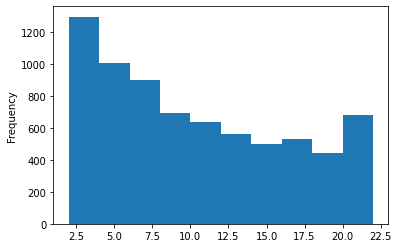

In [11]:
books_df.loc[books_df['max']<23, 'max'].plot(kind='hist')

Ao final, é possível observar a distribuição de quatidade de livros por gênero. Fantasia é o gênero com maior quantidade de livros e podemos perceber que a base não é perfeitamente balanceada.

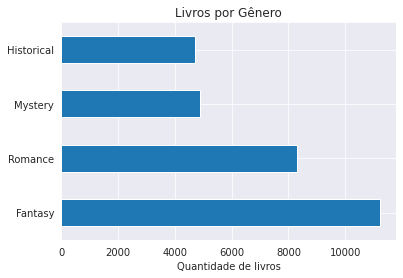

In [12]:
import seaborn as sns
sns.set_style("darkgrid")

books_df['genre'].value_counts().plot(kind='barh')
plt.xlabel('Quantidade de livros')
plt.title('Livros por Gênero')
#plt.savefig('livro_genero.png', format='png')

## Analisando o tamanho das descrições

Como a descrição do livro será a informação usada como preditor na rede neural foi necessário dedicar um tempo à sua análise. Antes de usar a descrição em um RNN, é necessário garantir que todas tenha o mesmo formato e comprimento. Usar inputs com um comprimento fixo facilita o treinamento, já que os pesos permanecem mais estáveis. Assim, é necessário primeiro determinar qual o comprimento ideal. Para isso foram analisados os gráficos abaixo:

Text(0.5, 1.0, 'Histograma de tamanho das descrições')

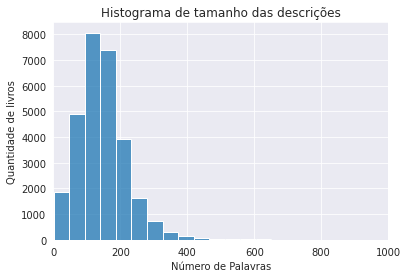

In [13]:
sns.histplot(books_df['description'].apply(lambda x: len(x.split())), bins=30)
plt.xlabel('Número de Palavras')
plt.ylabel('Quantidade de livros')
plt.xlim([0,1000])
plt.title('Histograma de tamanho das descrições')
#plt.savefig('desc_hist.png', format='png')

/home/aguilartaina/.local/share/virtualenvs/TCC-1cunMaiW/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribuição cumulativa do tamanho das descrições')

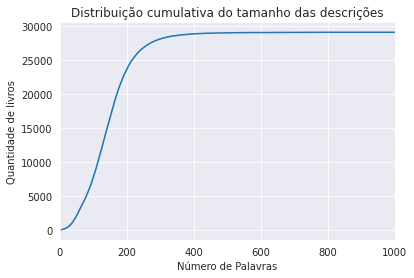

In [14]:
s = books_df['description'].apply(lambda x: len(x.split())).sort_values(ignore_index=True)
sns.lineplot(s, s.index)
plt.xlabel('Número de Palavras')
plt.ylabel('Quantidade de livros')
plt.xlim([0,1000])
plt.title('Distribuição cumulativa do tamanho das descrições')
#plt.savefig('desc_cum.png', format='png')

Por fim, foi analisada a matriz de correlação entre os gêneros, para verificar se é válido
manter todos ou se existe gêneros que estão relacionados.

In [16]:
books_df[['fantasy','historical','mistery','romance']].divide(books_df['max'], axis=0).corr()

,fantasy,historical,mistery,romance
fantasy,1.000000,-0.363323,-0.327287,-0.342259
historical,-0.363323,1.000000,-0.146479,-0.250634
mistery,-0.327287,-0.146479,1.000000,-0.298473
romance,-0.342259,-0.250634,-0.298473,1.000000


## Salvando os arquivos tratados

As informações de descrição e gênero foram salvas em csv, para o treinamento do modelo no ambiente do Colab.

In [15]:
books_df.loc[:, ['description', 'genre']].to_csv('df_xlabel')

## Analisando o resultado do modelo

Após o treinamento, as predições foram salvas em um arquivo csv para serem analizadas.

In [19]:
test_df = pd.read_csv('df_test.csv', index_col=0)
test_df = books_df.merge(test_df)
test_df['error'] = test_df['genre'] != test_df['pred_genre']
test_df = test_df.drop(['index', 'book_id', 'language', 'authors', 'shelves'], axis=1)

A primeira coisa foi procurar colunas que possuiam alguma distribuição diferente entre os livros preditos de maneira correta e os livros preditos de maneira incorreta. Podemos observar uma diferença significativa na distribuição da colunas max.

In [20]:
test_df[test_df['error']].describe()

,pages,rating,rating_count,review_count,fantasy,historical,mistery,romance,max
count,1270.000000,1302.000000,1.302000e+03,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000,1302.000000
mean,347.353543,3.945061,2.436585e+04,1412.540707,104.354071,65.599078,57.689708,88.733487,235.617512
std,259.272633,0.279776,1.088853e+05,3833.903995,347.249515,347.816592,320.517851,305.958954,595.648309
min,0.000000,2.520000,1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,245.000000,3.770000,1.458250e+03,115.000000,0.000000,0.000000,0.000000,0.000000,16.000000
50%,325.000000,3.950000,4.778000e+03,350.000000,0.000000,0.000000,0.000000,2.000000,61.500000
75%,400.000000,4.140000,1.415425e+04,1063.250000,45.000000,8.000000,19.000000,57.750000,199.750000
max,6576.000000,5.000000,2.045636e+06,51846.000000,4894.000000,9131.000000,9161.000000,5141.000000,9161.000000


In [21]:
test_df[~test_df['error']].describe()

,pages,rating,rating_count,review_count,fantasy,historical,mistery,romance,max
count,4473.000000,4582.000000,4.582000e+03,4582.000000,4582.000000,4582.000000,4582.000000,4582.000000,4582.000000
mean,345.314778,3.990567,2.647633e+04,1482.625928,277.141423,61.389568,58.820384,107.362942,449.849847
std,184.875673,0.266298,1.294420e+05,5104.898029,1213.910729,309.392844,276.369766,409.883552,1290.451952
min,0.000000,2.810000,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,246.000000,3.820000,1.675250e+03,120.250000,0.000000,0.000000,0.000000,0.000000,26.000000
50%,328.000000,4.000000,5.648000e+03,358.000000,0.000000,0.000000,0.000000,0.000000,102.000000
75%,404.000000,4.170000,1.612825e+04,1090.250000,88.000000,0.000000,0.000000,50.000000,393.750000
max,2700.000000,5.000000,4.471566e+06,132746.000000,24394.000000,8455.000000,10080.000000,8884.000000,24394.000000


Como já foi mencionado alguns livro possuim poucos votos no gênero principal, o que poderia afetar a qualidade dos dados e, como consequência, a qualidade do modelo. O gráfico mostra que essa teoria pode estar correta, pois a distribuição de votos no gênero principal é bastante diferente nos casos de acerto e de erro na base de teste.

(0.0, 3000.0)

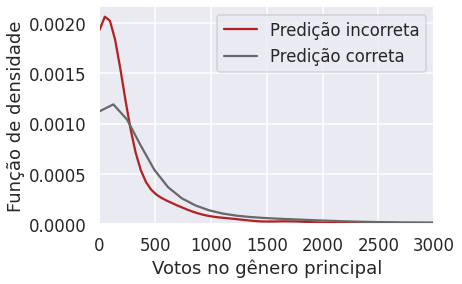

In [22]:
sns.set_context('talk')
sns.kdeplot(test_df[test_df['error']]['max'], color='firebrick', label='Predição incorreta', cut=0)
sns.kdeplot(test_df[~test_df['error']]['max'], color='dimgray', label='Predição correta', cut=0)
plt.legend()
plt.xlabel('Votos no gênero principal')
plt.ylabel('Função de densidade')
plt.xlim([0,3000])
#plt.savefig('dens_genero.png', format='png', bbox_inches='tight')

Uma possível fonte de erro poderia ser o truncamento da descrição do livro. Pois para algumas observações, parte da informação foi perdida. Para avaliar se existiu algum impacto, comparou-se a distribuição de número de palavras tanto para livros classificados incorretamente quanto para livros classificados corretamente. Porém, é possível observar que as duas distribuições são muito parecidas, portanto o truncamento não pode ser considerado uma fonte de erro.

(0.0, 500.0)

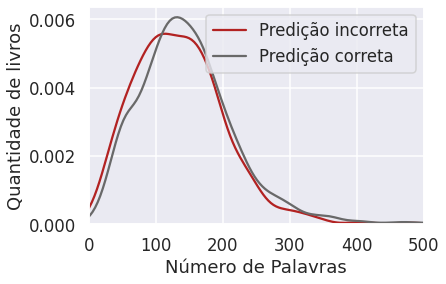

In [23]:
sns.kdeplot(test_df[test_df['error']]['description'].apply(lambda x: len(x.split())), label='Predição incorreta', color='firebrick')
sns.kdeplot(test_df[~test_df['error']]['description'].apply(lambda x: len(x.split())), label='Predição correta', color='dimgray')
plt.legend()
plt.xlabel('Número de Palavras')
plt.ylabel('Quantidade de livros')
plt.xlim([0,500])
#plt.title('Densidade do tamanho das descrições')
#plt.savefig('desc_hist_err.png', format='png', bbox_inches='tight')

Como era de se esperar, a classe com o maior número de observações obteve o melhor resultado. Livros de fantasia são previstos como livros de fantasia em 86% das vezes. Dependendo do contexto, isso pode mostrar um classificador enviesado, ou poderia ser considerado apenas um classificador muito bom em prever esse tipo de gênero. Esse é um ponto a ser avaliado de acordo com o contexto de negócio que o problema está inserido. Um ponto que poderia ser
avaliado é se livros de fantasia realmente representam a maior parte do conjunto de livros, ou se é algo relacionado a amostra escolhida. Isso também serve como guia para definir se esse desbalanceamento de classes deveria ser corrigido.

In [19]:
pivot = pd.pivot_table(test_df[['pred_genre', 'genre', 'pages']], index='pred_genre', columns='genre', aggfunc='count')
pivot/pivot.sum(axis=0)

pages                               
genre        Fantasy Historical   Mystery   Romance
pred_genre                                         
Fantasy     0.862568   0.122995  0.170782  0.152709
Historical  0.041591   0.722995  0.047325  0.052956
Mystery     0.037975   0.073797  0.706790  0.054187
Romance     0.057866   0.080214  0.075103  0.740148

In [20]:
pivot = pd.pivot_table(test_df[['pred_genre', 'genre', 'pages']], index='genre', columns='pred_genre', aggfunc='count')
pivot/pivot.sum(axis=0)

pages                               
pred_genre   Fantasy Historical   Mystery   Romance
genre                                              
Fantasy     0.782930   0.102222  0.090517  0.086604
Historical  0.047189   0.751111  0.074353  0.050744
Mystery     0.068117   0.051111  0.740302  0.049391
Romance     0.101764   0.095556  0.094828  0.813261